In [1]:
import autograd
from autograd.builtins import tuple
import autograd.numpy as np

from scipy.integrate import odeint as BlackBox
import matplotlib.pyplot as plt

from scipy.stats import lognorm

%matplotlib inline

In [2]:
def f(y,t,theta):
    '''Function describing dynamics of the system'''
    S,I = y
    
    ds = -theta*S*I
    di = theta*S*I - I
    
    return np.array([ds,di])

#Jacobian wrt y
J = autograd.jacobian(f,argnum=0)
#Gradient wrt theta
grad_f_theta = autograd.jacobian(f,argnum=2)


def ODESYS(Y,t,theta):

    #Y will be length 4.
    #Y[0], Y[1] are the ODEs
    #Y[2], Y[3] are the sensitivities
    
        
    dy_dt = f(Y[0:2],t,theta)

    grad_y_theta = J(Y[:2],t,theta)@Y[-2::] + grad_f_theta(Y[:2],t,theta)

    return np.concatenate([dy_dt,grad_y_theta])

def Cost(y_obs):
    def cost(Y):
        '''Squared Error Loss'''
        n = y_obs.shape[0]
        err = np.linalg.norm(y_obs - Y, 2, axis = 1)
        
        return np.sum(err)/n
    
    return cost

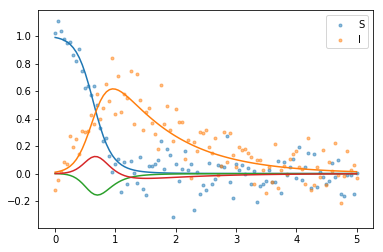

In [4]:
## Generate Data
#Initial Condition
np.random.seed(19920908)
Y0 = np.array([0.99,0.01, 0.0, 0.0])
#Space to compute solutions
t = np.linspace(0,5,101)
#True param value
theta = 8.0

sol = BlackBox(ODESYS, y0 = Y0, t = t, args = tuple([theta]))

fig,ax = plt.subplots()

plt.plot(t,sol)

#Corupt the observations with noise
y_obs = sol[:,:2] + np.random.normal(0,0.1,size = sol[:,:2].shape)

plt.scatter(t,y_obs[:,0], marker = '.', alpha = 0.5, label = 'S')
plt.scatter(t,y_obs[:,1], marker = '.', alpha = 0.5, label = 'I')


plt.legend()

In [7]:

theta_iter = 1.5
cost = Cost(y_obs[:,:2])
grad_C = autograd.grad(cost)

maxiter = 250
learning_rate = 1 #Big steps
for i in range(maxiter):

    sol = BlackBox(ODESYS,y0 = Y0, t = t, args = tuple([theta_iter]))
    
    Y = sol[:,:2]

    theta_iter -=learning_rate*(grad_C(Y)*sol[:,-2:]).sum()
    
    if i%10==0:
        print(theta_iter)
        
print('YYYEAAAAHHH!')
    
    

1.6940465623342957
3.8042659509977326
4.682673164110949
5.240061441938889
5.682292755565281
6.05306578544529
6.366133878755359
6.638191429401394
6.881297985418057
7.094845216958768
7.274357336819247
7.414271345814574
7.521659359015914
7.61055792731981
7.684202436289883
7.745169543769566
7.795695762991526
7.837685441896926
7.8727136237883295
7.902056338935023
7.926736437855073
7.947571646688853
7.965217475485848
7.98020255783281
7.992956398286919
YYYEAAAAHHH!


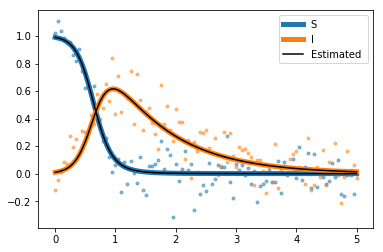

In [8]:
sol = BlackBox(ODESYS, y0 = Y0, t = t, args = tuple([theta_iter]))
true_sol = BlackBox(ODESYS, y0 = Y0, t = t, args = tuple([theta]))


plt.plot(t,sol[:,0], label = 'S', color = 'C0', linewidth = 5)
plt.plot(t,sol[:,1], label = 'I', color = 'C1', linewidth = 5)

plt.scatter(t,y_obs[:,0], marker = '.', alpha = 0.5)
plt.scatter(t,y_obs[:,1], marker = '.', alpha = 0.5)


plt.plot(t,true_sol[:,0], label = 'Estimated ', color = 'k')
plt.plot(t,true_sol[:,1], color = 'k')

plt.legend()
plt.savefig('final.png', dpi = 800)